<center>
    <h1> Machine Learning para economistas <br>
         Taller No. 2 </h1>
    <h2> Luis Ángel Mazabuel García </h2>
    <h3> 15 de junio de 2020 </h3>
</center> <br><br>
<h2> 1. Desarrolle un modelo que permita pronosticar cuál será la probabilidad de rotación de un cliente. Para ello: </h2><br>
<h3> a) Deﬁna el conjunto de parámetros a utilizar en la modelación, justiﬁcando su respuesta con apoyo de gráﬁcos. </h3>

In [1]:
#conda install tzlocal

In [2]:
#conda install rpy2

In [3]:
#pip install imbalanced-learn

In [4]:
#pip install hyperopt

In [5]:
#pip install pmdarima

In [160]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statistics 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import statsmodels.api as sm2
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.vector_ar.var_model import VAR

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

from sklearn.metrics import confusion_matrix, precision_score, accuracy_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score, roc_curve 

########################## ENTORNO SQL ####################################################
from sqlalchemy import create_engine, text
pd.options.display.max_rows = 10
df = pd.read_excel('Taller2.xlsx')

engine=create_engine('sqlite://')
bd = df.to_sql('df', engine, if_exists='replace', index=False)

def runQuery(sql):
    result = engine.connect().execute((text(sql)))
    return pd.DataFrame(result.fetchall(), columns=result.keys())



%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [8]:
%%R

 install.packages("ggplot2")
 install.packages("grid")
 install.packages("gridExtra")
 install.packages("readxl")
 install.packages("readr")
 install.packages("dplyr")
 install.packages("kableExtra")

library(ggplot2)
library(grid)
library(gridExtra)
library(readxl)
library(readr)
library(dplyr)
library(kableExtra)

rdf = read_excel("Taller2.xlsx", col_types = c("numeric", 
    "numeric", "text", "text", "numeric", 
    "numeric", "numeric", "numeric", "numeric", 
    "numeric", "numeric", "numeric"))

In [9]:
########################## ENTORNO DE R ####################################################
import rpy2.robjects as robjects
import rpy2.robjects.lib.ggplot2 as ggplot2

C:\Users\NECSOFT\anaconda3\lib\site-packages\rpy2\robjects\lib\ggplot2.py:67: UserWarning: This was designed againt ggplot2 version 2.2.1 but you have 3.3.2
  warnings.warn('This was designed againt ggplot2 version %s but you have %s' % (TARGET_VERSION, ggplot2.__version__))


Lo primero que se debe realizar es una lectura y revisión de los datos para poder asegurarnos de que los tipos de los objetos son adecuados para procesar de la mejor manera los datos:

In [10]:
print(df.dtypes)
df.head()

Numero de Identificación      int64
Score                         int64
Departamento                 object
Genero                       object
Edad                          int64
                             ...   
NumProducto                   int64
TarjetaCredito                int64
EsunMienbroActivo             int64
Salario                     float64
Rotación                      int64
Length: 12, dtype: object


,Numero de Identificación,Score,Departamento,Genero,Edad,Tenencia,Balance,NumProducto,TarjetaCredito,EsunMienbroActivo,Salario,Rotación
0,15634602,619,Antioquia,Mujer,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Bogotá,Mujer,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,Antioquia,Mujer,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,Antioquia,Mujer,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Bogotá,Mujer,43,2,125510.82,1,1,1,79084.10,0


Ya que los objetos bajo los cuales Python se encuentra leyendo nuestros datos están correctamente definidos, se procede ahora a realizar una revisión de registros duplicados (y si hay se eliminarán), además de revisar si hay valores faltantes (NA) para determinar si los datos están balanceados o no.

In [11]:
print("Registros duplicados:",df.duplicated().sum(),"\n\nValores Faltantes:\n")
print(df.isna().sum())

Registros duplicados: 0 

Valores Faltantes:

Numero de Identificación    0
Score                       0
Departamento                0
Genero                      0
Edad                        0
                           ..
NumProducto                 0
TarjetaCredito              0
EsunMienbroActivo           0
Salario                     0
Rotación                    0
Length: 12, dtype: int64


Dado que se encuentra bien, es posible ahora proceder a un análisis descriptivo de nuestros datos con la finalidad de decidir si es necesario convertir o transformar el comportamiento de alguna variable para eliminar, en lo posible, problemas de Sesgo o Varianza desde el inicio. Así, se buscará asemejar nuestro modelo a una distribución que nos permita trabajar de la mejor manera en cada caso.

In [12]:
df.describe()

,Numero de Identificación,Score,Edad,Tenencia,Balance,NumProducto,TarjetaCredito,EsunMienbroActivo,Salario,Rotación
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Tras la validación de los distintos aspectos sobre los datos, a continuación se realizará una interpretación de cuales variables resultan teóricamente relevantes para el modelo para continuar, así, con un validación de estadística descriptiva sobre los datos y determinar si son necesarios algunos cambios sobre estas variables (Transformación logarítimca, normalización, estandarización, etc.).

### Número de Identificación:
Esta variable nos sirve como índice, llave primaria mediante la cual pudimos validar que no hay registros duplicados en los datos.
## <center> Variable Endógena (Explicada) </center>
### Rotación:
En este caso es la variable endógena a pronosticar. Siendo sus valores binarios, se entiende que toma el valor de 1 cuando el cliente se translada, rota, de entidad bancaria, 0 en el caso contrario. En adelante se verán las diferentes variables regresoras mediante las cuales se pretende estimar la probabilidad de que el cliente rote (1) o no (0).

## <center> Variables Explicativas </center>
### Score:
Los datos de esta variable son especialmente importantes ya que dentro del contexto bancario el Score de un cliente indica qué tan buen comportamiento tiene, se sabe que conforme se tienen buenas prácticas crediticias (pagar a tiempo, obtener más productos y mantenerlos al día, etc.) se aumenta el Score, mientras que retrasarse en los pagos, brindar información falsa o solicitar muchos créditos disminuye el valor de esta calificación. En el ejercicio de estimar la probabilidad de que un cliente se mantenga en la misma entidad bancaria o se traslade (Rotación).

### Balance:
La diferencia que se encuentra entre los activos y pasivos de cada cliente del banco. Con la información de esta variable se puede conocer mejor las características financieras de los clientes del banco, un cliente con más activos que pasivos será alguien atractivo para el banco ya que sus ingresos superan sus deudas y obligaciones; mientras que un cliente con más pasivos que activos se espera que esté más propenso a dejar su entidad bancaria actual para que otra entidad compre cartera o le ofrezca menores tasas de interés para amortizar y saldar sus deudas.

### NumProducto:
Es el número de productos que tiene el cliente en la entidad bancaria. Se esperaría que a mayor número de productos, el cliente esté más vinculado con el banco y su probabilidad de rotación sea menor, además también asegura en cierta medida el tiempo de permanencia que lleva el cliente pues a mayor cantidad de productos se esperaría mayor historial de permanencia con el banco; clientes nuevos tendrían pocos productos con el banco, por ejemplo, y su probabilidad de rotación -debido mejores ofertas, referencias o mayor interés propio- sería mayor.

### TarjetaCredito:
Variable binaria que indica si el cliente posee una tarjeta de crédito con el banco (1) o si no (0). Se esperaría que los clientes que sí tienen tarjeta de crédito tengan menor probabilidad de rotación de entidad bancaria dado que su confianza y compromiso con la entidad es mayor al comprometerse mensualmente a ciertas cláusulas.

### EsunMiembroActivo:
Adicional a los anteriores datos de los clientes, esta variable binaria indicará si el individuo tiene actividad reciente en la entidad (1) o no (0). Clientes con poca actividad reciente, a pesar de tener varios productos, un buen balance e inclusive un buen score crediticio, son clientes con alta probabilidad de rotar de entidad bancaria o dejarla. Por ello, es un dato sumamente importante ya que a los bancos les interesaría conocer dentro de su base de datos cuáles son estos clientes para aplicar sobre ellos políticas de retención y fidelización para evitar que dejen la entidad bancaria.

## <center> Variables Control </center>
### Departamento:
Esta variable, que contiene 3 departamentos de ubicación de los clientes (Antioquia, Bogotá, Santander) será convertida a variable binaria tal que cuando la variable binaria Departamento_Bogotá toma el valor de 1, el individuo está ubicado en Bogotá; cuando Departamento_Santander es igual a 1, el individuo está ubicado en Santander; en caso de que ambas sean iguales a 0, el cliente está ubicado en Antioquia. Esta variable servirá para determinar si la ubicación de un cliente influye de alguna manera en que estos individuos sean más propensos a transladarse de entidad bancaria o a pertenecer en ella.

### Genero:
Al igual que la anterior, esta variable será convertida a variable binaria tal que cuando GeneroCODE toma el valor de 1 el individuo es Mujer y de lo contrario es Hombre. Mediante esta información será posible determinar si el sexo del cliente influye en ser más propenso a rotar de entidad bancaria o no.

### Edad:
Indica la edad de los clientes y mediante esta información podría conocerse si las personas jovenes son más propensas a las personas mayores a dejar su entidad bancaria por trasladarse a otra o viceversa.

### Tenencia:
Al no tener una interpretación teórica clara en el contexto que se está manejando, esta variable se descartará para que no afecte positiva ni negativamente los modelos a estimar.

In [13]:
print(df.Departamento.value_counts(),"\n\n",df.Genero.value_counts())

Antioquia    5014
Santander    2509
Bogotá       2477
Name: Departamento, dtype: int64 

 Hombre    5457
Mujer     4543
Name: Genero, dtype: int64


In [14]:
df = df.drop('Tenencia', axis=1)
df.Genero = pd.Categorical(df.Genero)
df['GeneroCODE'] = df.Genero.cat.codes
df = pd.get_dummies(df, columns=['Departamento'], drop_first= True)
df.head()

,Numero de Identificación,Score,Genero,Edad,Balance,NumProducto,TarjetaCredito,EsunMienbroActivo,Salario,Rotación,GeneroCODE,Departamento_Bogotá,Departamento_Santander
0,15634602,619,Mujer,42,0.00,1,1,1,101348.88,1,1,0,0
1,15647311,608,Mujer,41,83807.86,1,0,1,112542.58,0,1,1,0
2,15619304,502,Mujer,42,159660.80,3,1,0,113931.57,1,1,0,0
3,15701354,699,Mujer,39,0.00,2,0,0,93826.63,0,1,0,0
4,15737888,850,Mujer,43,125510.82,1,1,1,79084.10,0,1,1,0


## <center> Validación de la muestra </center>
### ¿Los datos están balanceados?

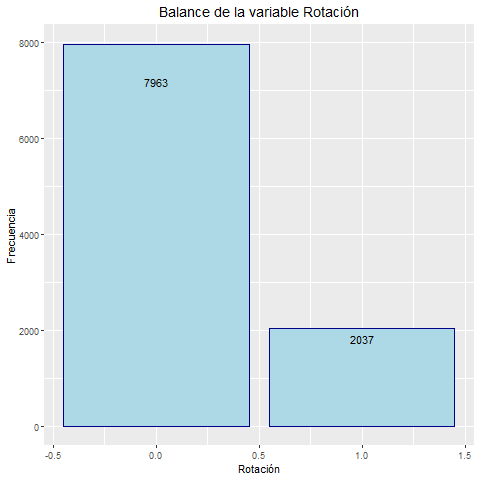

In [15]:
%%R
rdf = subset(rdf, select = -c(Tenencia) )
ggplot(rdf, mapping= aes(x = Rotación, y = ..count..))+
    geom_bar(color= "darkblue", fill= "lightblue")+
    geom_text(aes(label=..count..),stat="count",position=position_stack(0.9))+
    labs(title= "Balance de la variable Rotación", y= "Frecuencia")+
    theme(plot.title = element_text(size=14, face="plain", hjust=0.5))

Los datos no se encuentran balanceados, sobre las 10.000 observaciones disponibles, 7963 responden a clientes que sí rotaron de entidad bancaria y 2037 clientes que no han rotado de entidad bancaria. Para eliminar sesgo en los modelos que se realizarán y asegurar una correcta interpretación de los estimadores se procede a balancear la muestra:

In [16]:
y = df.Rotación
X = df.drop(['Rotación','Genero'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)
sm = SMOTE(random_state=27, sampling_strategy=1)
X_train, y_train = sm.fit_sample(X_train, y_train)
np.array(np.unique(y_train, return_counts=True)).T

array([[   0, 5975],
       [   1, 5975]], dtype=int64)

## <center> Estadística Descriptiva </center>

Ahora que se balancearon los datos disponibles, se procederá a revisar la estadística descriptiva de los datos para determinar si hay que realizar alguna transformación sobre alguna de las variables disponibles:

In [17]:
df2 = pd.concat([X_train,y_train], axis= 1)
df2.to_csv("dfbalanceada.csv", index=False)
df2.describe()

,Numero de Identificación,Score,Edad,Balance,NumProducto,TarjetaCredito,EsunMienbroActivo,Salario,GeneroCODE,Departamento_Bogotá,Departamento_Santander,Rotación
count,1.195000e+04,11950.000000,11950.000000,11950.000000,11950.000000,11950.000000,11950.000000,11950.000000,11950.000000,11950.000000,11950.000000,11950.000000
mean,1.569012e+07,647.921590,40.942594,82656.325299,1.415481,0.614310,0.375397,101334.586356,0.395900,0.170879,0.253138,0.500000
std,7.240993e+04,91.251649,10.006210,61016.493637,0.567492,0.486778,0.484246,57463.858005,0.489064,0.376419,0.434828,0.500021
min,1.556570e+07,350.000000,18.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000
25%,1.562787e+07,586.000000,34.000000,0.000000,1.000000,0.000000,0.000000,53326.466419,0.000000,0.000000,0.000000,0.000000
50%,1.568826e+07,648.000000,40.000000,104183.931540,1.000000,1.000000,0.000000,101867.733086,0.000000,0.000000,0.000000,0.500000
75%,1.575281e+07,711.000000,47.000000,129540.122500,2.000000,1.000000,1.000000,150773.561722,1.000000,0.000000,1.000000,1.000000
max,1.581566e+07,850.000000,92.000000,238387.560000,4.000000,1.000000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000


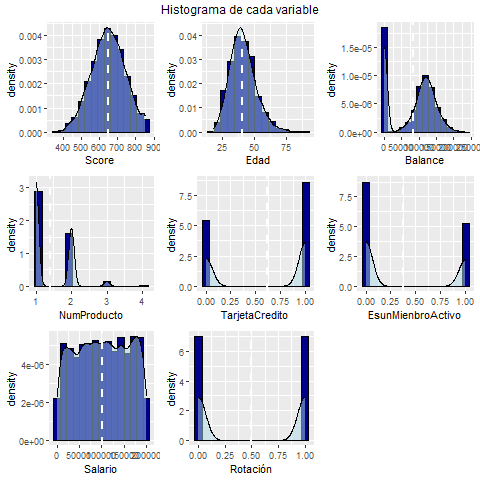

In [18]:
%%R
rdf2 <- read_csv("dfbalanceada.csv")


k <- 1 + 3.322 * log(nrow(rdf2),10)                  #Regla de Sturges para saber la cantidad de bins adecuados.
k <- round(k)
h1 <- ggplot(data = rdf2, mapping = aes(x = Score))+
  geom_histogram(aes(y=..density..), bins = k, fill = "darkblue", color = "black")+
  geom_density(alpha = 0.5, fill="lightblue")+
  geom_vline(aes(xintercept=mean(Score)), color="white", linetype="dashed", size=1)
h2 <- ggplot(data = rdf2, mapping = aes(x = Edad))+
  geom_histogram(aes(y=..density..), bins = k, fill = "darkblue", color = "black")+
  geom_density(alpha = 0.5, fill="lightblue")+
  geom_vline(aes(xintercept=mean(Edad)), color="white", linetype="dashed", size=1)
h3 <- ggplot(data = rdf2, mapping = aes(x = Balance))+
  geom_histogram(aes(y=..density..), bins = k, fill = "darkblue", color = "black")+
  geom_density(alpha = 0.5, fill="lightblue")+
  geom_vline(aes(xintercept=mean(Balance)), color="white", linetype="dashed", size=1)
h4 <- ggplot(data = rdf2, mapping = aes(x = NumProducto))+
  geom_histogram(aes(y=..density..), bins = k, fill = "darkblue", color = "black")+
  geom_density(alpha = 0.5, fill="lightblue")+
  geom_vline(aes(xintercept=mean(NumProducto)), color="white", linetype="dashed", size=1)
h5 <- ggplot(data = rdf2, mapping = aes(x = TarjetaCredito))+
  geom_histogram(aes(y=..density..), bins = k, fill = "darkblue", color = "black")+
  geom_density(alpha = 0.5, fill="lightblue")+
  geom_vline(aes(xintercept=mean(TarjetaCredito)), color="white", linetype="dashed", size=1)
h6 <- ggplot(data = rdf2, mapping = aes(x = EsunMienbroActivo))+
  geom_histogram(aes(y=..density..), bins = k, fill = "darkblue", color = "black")+
  geom_density(alpha = 0.5, fill="lightblue")+
  geom_vline(aes(xintercept=mean(EsunMienbroActivo)), color="white", linetype="dashed", size=1)
h7 <- ggplot(data = rdf2, mapping = aes(x = Salario))+
  geom_histogram(aes(y=..density..), bins = k, fill = "darkblue", color = "black")+
  geom_density(alpha = 0.5, fill="lightblue")+
  geom_vline(aes(xintercept=mean(Salario)), color="white", linetype="dashed", size=1)
h8 <- ggplot(data = rdf2, mapping = aes(x = Rotación))+
  geom_histogram(aes(y=..density..), bins = k, fill = "darkblue", color = "black")+
  geom_density(alpha = 0.5, fill="lightblue")+
  geom_vline(aes(xintercept=mean(Rotación)), color="white", linetype="dashed", size=1)

grid.arrange(h1, h2, h3, h4, h5, h6, h7, h8, ncol= 3,
     top = textGrob("Histograma de cada variable"))

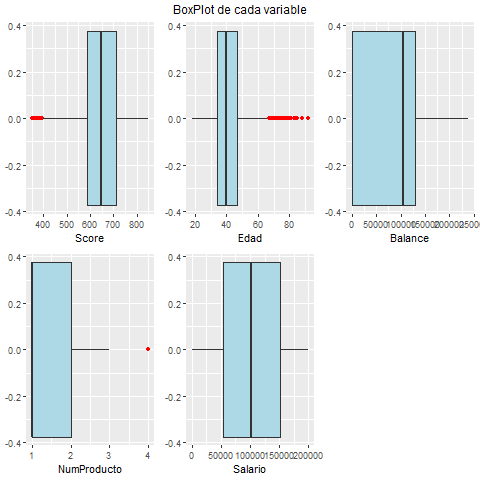

In [19]:
%%R
b1 = ggplot(data = rdf2)+
      geom_boxplot(mapping = aes(x = Score), outlier.color = "red", fill = "lightblue")
b2 = ggplot(data = rdf2)+
      geom_boxplot(mapping = aes(x = Edad), outlier.color = "red", fill = "lightblue")
b3 = ggplot(data = rdf2)+
      geom_boxplot(mapping = aes(x = Balance), outlier.color = "red", fill = "lightblue")
b4 = ggplot(data = rdf2)+
      geom_boxplot(mapping = aes(x = NumProducto), outlier.color = "red", fill = "lightblue")
b7 = ggplot(data = rdf2)+
      geom_boxplot(mapping = aes(x = Salario), outlier.color = "red", fill = "lightblue")
grid.arrange(b1, b2, b3, b4, b7, ncol= 3,
     top = textGrob("BoxPlot de cada variable"))

### <center> Normalización de Salario </center>

Sobre las anteriores gráficas y valores obtenidos, es posible notar una anomalía presente en la varianza de **Salario**: mientras hay usuarios que registran un nivel de ingreso de 11.5, hay otros que ascienden hasta los 200,000.00 aproximadamente. Por este motivo se realiza una transformación logarítmica y dos normalizaciones: Estandarizando (StandarScaler) y Escalando por rango (MinMaxScaler). Ya que en los datos de Salario NO hay datos atípicos (Observar boxplot justo arriba ), no se incluirá la Normalización Escalar Robusta (RobustScaler).

In [20]:
std_scaler = StandardScaler()
MM_scaler = MinMaxScaler()
df2['SalarioSTD'] = std_scaler.fit_transform(df2['Salario'].values.reshape(-1,1))
df2['SalarioMinMax'] = MM_scaler.fit_transform(df2['Salario'].values.reshape(-1,1))
df2.to_csv("dfbalanceada.csv", index= False)
df2.iloc[:,[7,12,13]].describe()

,Salario,SalarioSTD,SalarioMinMax
count,11950.000000,1.195000e+04,11950.000000
mean,101334.586356,7.636848e-17,0.506663
std,57463.858005,1.000042e+00,0.287347
min,11.580000,-1.763321e+00,0.000000
25%,53326.466419,-8.354839e-01,0.266600
50%,101867.733086,9.278337e-03,0.509329
75%,150773.561722,8.603850e-01,0.753882
max,199992.480000,1.716940e+00,1.000000


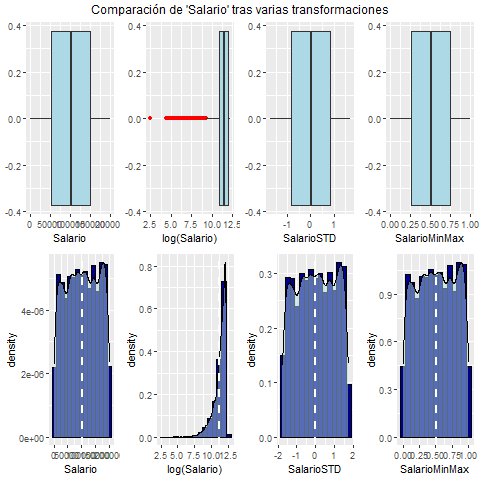

In [21]:
%%R
rdf2 = read.csv("dfbalanceada.csv")
blog8 = ggplot(data = rdf2)+
      geom_boxplot(mapping = aes(x = log(Salario)), outlier.color = "red", fill = "lightblue")

bstd8 = ggplot(data = rdf2)+
      geom_boxplot(mapping = aes(x = SalarioSTD), outlier.color = "red", fill = "lightblue")

bmm8 = ggplot(data = rdf2)+
      geom_boxplot(mapping = aes(x = SalarioMinMax), outlier.color = "red", fill = "lightblue")

hlog7 = ggplot(data = rdf2, mapping = aes(x = log(Salario)))+
  geom_histogram(aes(y=..density..), bins = k, fill = "darkblue", color = "black")+
  geom_density(alpha = 0.5, fill="lightblue")+
  geom_vline(aes(xintercept=mean(log(Salario))), color="white", linetype="dashed", size=1)

hstd7 = ggplot(data = rdf2, mapping = aes(x = SalarioSTD))+
  geom_histogram(aes(y=..density..), bins = k, fill = "darkblue", color = "black")+
  geom_density(alpha = 0.5, fill="lightblue")+
  geom_vline(aes(xintercept=mean(SalarioSTD)), color="white", linetype="dashed", size=1)

hmm7 = ggplot(data = rdf2, mapping = aes(x = SalarioMinMax))+
  geom_histogram(aes(y=..density..), bins = k, fill = "darkblue", color = "black")+
  geom_density(alpha = 0.5, fill="lightblue")+
  geom_vline(aes(xintercept=mean(SalarioMinMax)), color="white", linetype="dashed", size=1)

grid.arrange(b7, blog8, bstd8, bmm8,h7,hlog7, hstd7, hmm7, ncol= 4,
     top = textGrob("Comparación de 'Salario' tras varias transformaciones"))

Tras la revisión de la transformación a <b>Logaritmo</b>, <b>normalización Estandar</b> y <b>normalización Escalar</b>, es visible que la transformación logarítmica no funciona ya que aumenta excesivamente la asimetría de la variable generando muchos nuevos valores atípicos (outliers). Se observa que la normalización mantiene la misma función de densidad de la variable, pero transforma los rangos dentro de los cuales se distribuyen los datos. Para este caso en específico no parece tener sentido decir que el nivel de ingresos de un cliente es <b>negativo</b> por lo cual finalmente <b>se elige la normalización Escalar por mínimos y máximos</b> ya que guarda las proporciones a escala de la variable dentro de un rango entre 0 y 1 lo cual permite una interpretación teórica coherente.

<h3> b) Con las distintas técnicas conocidas, construya distintos modelos que pronóstiquen la probabilidad de rotación de un cliente. </h3>

<h3><center> Regresión Logística (Logit) </center></h3>


In [22]:
df2 = df2.drop(['Salario', 'SalarioSTD'], axis=1)

y = df2.Rotación
X = df2.drop('Rotación', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

logit = LogisticRegression(solver='lbfgs')
logit_model = logit.fit(X_train,y_train)
logit_pred = logit_model.predict(X_test)
logit_roc_auc = roc_auc_score(y_test, logit_pred)

<h3><center> Ingenuo de Bayes (NB) </center></h3>

In [23]:
def hyperopt_train_test(params):
    clf = BernoulliNB(**params)
    return cross_val_score(clf, X_train, y_train).mean()
space4knn = {
    'alpha': hp.uniform('alpha', 0.0, 2.0)
}

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=10, trials=trials)
print('best:')
print(best)

100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 14.83trial/s, best loss: -0.6979484328937933]
best:
{'alpha': 0.46272740426177594}


In [24]:
NaiveBayes = BernoulliNB(alpha=0.30112751194525633)
NB_model = NaiveBayes.fit(X_train,y_train)
NB_pred = NB_model.predict(X_test)
NB_roc_auc = roc_auc_score(y_test, NB_pred)

<h3><center> K Vecinos más cercanos (KNN) </center></h3>

In [25]:
def hyperopt_train_test(params):
    clf = KNeighborsClassifier(**params)
    return cross_val_score(clf, X_train, y_train).mean()
space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(2,10))
}
def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=10, trials=trials)
print('best:')
print(best)

100%|███████████████████████████████████████████████| 10/10 [00:04<00:00,  2.17trial/s, best loss: -0.5883756772368736]
best:
{'n_neighbors': 6}


In [26]:
KNN = KNeighborsClassifier(n_neighbors=2)
KNN_model = KNN.fit(X_train,y_train)
KNN_pred = KNN_model.predict(X_test)
KNN_roc_auc = roc_auc_score(y_test, KNN_pred)

<h3><center> Árboles de Decisión (DT) </center></h3>

In [27]:
def hyperopt_train_test(params):
    clf = DecisionTreeClassifier(**params)
    return cross_val_score(clf, X_train, y_train).mean()
space4dt = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,5)),
    'criterion': hp.choice('criterion', ["gini", "entropy"])
}
def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4dt, algo=tpe.suggest, max_evals=10, trials=trials)
print('best:')
print(best)

100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 12.80trial/s, best loss: -0.7848695447573898]
best:
{'criterion': 1, 'max_depth': 7, 'max_features': 3}


In [28]:
DT = DecisionTreeClassifier(criterion = "entropy", max_depth = 11, max_features = 3)
DT.fit(X_train,y_train)
DT_pred = DT.predict(X_test)
DT_roc_auc = roc_auc_score(y_test, DT_pred)

<h3><center> Random Forest (RF) </center></h3>

In [29]:
def hyperopt_train_test(params):
    clf = RandomForestClassifier(**params)
    return cross_val_score(clf, X_train, y_train).mean()
space4rf = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,5)),
    'n_estimators': hp.choice('n_estimators', range(1,20)),
    'criterion': hp.choice('criterion', ["gini", "entropy"])
}
best = 0
def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space4rf, algo=tpe.suggest, max_evals=10, trials=trials)
print('best:')
print(best)

100%|███████████████████████████████████████████████| 10/10 [00:04<00:00,  2.35trial/s, best loss: -0.8268247425503944]
best:
{'criterion': 1, 'max_depth': 13, 'max_features': 3, 'n_estimators': 11}


In [30]:
RF = RandomForestClassifier(criterion="gini", max_depth=12, max_features=3, 
                            n_estimators=12)
RF.fit(X_train,y_train)
RF_pred = RF.predict(X_test)
RF_roc_auc = roc_auc_score(y_test, RF_pred)

<h3><center> Gradient Boosting (GB) </center></h3>

In [31]:
def hyperopt_train_test(params):
    clf = GradientBoostingClassifier(**params)
    return cross_val_score(clf, X_train, y_train).mean()
space4rf = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,5)),
    'n_estimators': hp.choice('n_estimators', range(1,20)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1))}
best = 0
def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space4rf, algo=tpe.suggest, max_evals=3, trials=trials)
print('best:')
print(best)

100%|█████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.52s/trial, best loss: -0.8243700701139351]
best:
{'learning_rate': 0.2769173097960384, 'max_depth': 17, 'max_features': 0, 'n_estimators': 10}


In [32]:
GB = GradientBoostingClassifier(learning_rate= 0.010552184320591206,max_depth=17,max_features=1,n_estimators=8)
GB.fit(X_train, y_train)
GB_pred = GB.predict(X_test)
GB_roc_auc = roc_auc_score(y_test, GB_pred)

<h2> c) ¿Cuál es el mejor modelo? Justifique su respuesta con apoyo de gráficos pertinentes. </h2>
<h3><b> AUC </b></h3>

Ahora bien, para realizar la comparación de los modelos se revisará el rendimiento de cada modelo bajo el cálculo de la <b> Curva de de Característica Operativa del Recepto (ROC curve)</b> de manera que el modelo que alcance el mayor valor respecto a la <b>Tasa de Verdaderos Positivos (TPR)</b> frente a la <b>Tasa de Falsos Positivos(FPR)</b> en la curva de decisión será tomado como el modelo que mejor pronostica la variable de respuesta binaria en nuestro caso.

No obstante, revisar cada asignación de decisión posible en el <b>trade-off</b> entre la <b>TPR</b> y la <b>(FPR)</b> sería ineficiente. Por ello se procede a añadir el <b>Área Bajo la curva ROC (Under ROC curve Area - AUC)</b> mediante la cual se puede medir toda el área bidimensional por debajo de la curva ROC. El valor resultante para el <b>AUC</b> será interpretado como la probabilidad de que cada modelo clasifique un ejemplo positivo aleatorio más alto que un ejemplo negativo aleatorio. Es decir, un modelo cuyas predicciones siempre resultan incorrectas tiene un <b>AUC</b> de 0, mientras que otro modelo cuyas predicciones siempre resultan correctas tiene un <b>AUC</b> de 1.

<h3><b> MSE </b></h3>

Adicional al anterior criterio se añadirá el cálculo del <b> Error Cuadrático Promedio (Mean Square Error - MSE) </b> el cual consiste en calcular un proxy del error del modelo tomando la diferencia de la media de los residuos al cuadrado entre los datos de la variable endógena observados y los datos de la variable endógena estimados por cada modelo. El modelo con el menor <b> MSE </b> asociado tendrá mejores características de predición al insertar nuevos datos pues se concebirá bajo la Varianza Mínima de los residuos.

<h3><b> F1-Score </b></h3>

Finalmente, un último criterio para decidir cuál es el mejor modelo consiste en calcular el <b> Puntaje F1 </b> el cual, al igual que la curva ROC se calcula mediante los resultados obtenidos en la matriz de confusión del modelo. Para este caso se tiene en cuenta la Precisión: Evaluación de los datos por su desempeño en predicciones positivas, y la Sensibilidad: El número de predicciones positivas correctas dividido por el número total de positivos. De esta manera, el modelo con el mayor <b> Puntaje F1 </b> será preferido como modelo que mejor pronostica correctamente según los datos disponibles.

Así, tras haber realizado la estimación de los anteriores 6 modelos, se imprimirá a continuación los valores asociados al área bajo la curva ROC y se seleccionará como mejor modelo aquel que tenga mayor área bajo la curva.
<h3><center> Comparación de los modelos </center></h3>

In [33]:
def MeanSquareError(y_obs, y_pred):
    ''' This function calculates efficiency of any model 
    y_pred: estimate value
    y_obs: real value 
    # '''
    mse = pow(y_obs - y_pred, 2).sum() / y_obs.shape[0]
    return mse

In [34]:
print('     Modelo        ', '  AUC Value        ','      MSE Value         ','     F1 - Score        ')
print('Regresión Logit  : ',logit_roc_auc,'   ' ,MeanSquareError(y_test,  logit_pred),'   ' ,f1_score(y_test, logit_pred) )
print('Naïve Bayes      : ',NB_roc_auc   ,'   ' ,MeanSquareError(y_test,  NB_pred   ),'   ' ,f1_score(y_test, NB_pred   ) )
print('K Near Neighbor  : ',KNN_roc_auc  ,'   ' ,MeanSquareError(y_test,  KNN_pred  ),'  '  ,f1_score(y_test, KNN_pred  ) )
print('Árbol de decisión: ',DT_roc_auc   ,'   ' ,MeanSquareError(y_test,  DT_pred   ),'  '  ,f1_score(y_test, DT_pred   ) )
print('Random Forest    : ',RF_roc_auc   ,'    ', MeanSquareError(y_test, RF_pred   ),'  '  ,f1_score(y_test, RF_pred   ) )
print('Gradient Boosting: ',GB_roc_auc   ,'   ' ,MeanSquareError(y_test,  GB_pred   ),'  '  ,f1_score(y_test, GB_pred   ) )

     Modelo           AUC Value               MSE Value               F1 - Score        
Regresión Logit  :  0.5688898189489684     0.4327309236947791     0.6113615870153292
Naïve Bayes      :  0.7066699049486566     0.2938420348058902     0.7143786597267405
K Near Neighbor  :  0.5797719699807675     0.41767068273092367    0.4786967418546366
Árbol de decisión:  0.7848793441224285     0.21519410977242304    0.7837201479986545
Random Forest    :  0.835803419554085      0.1643239625167336    0.8354006034193764
Gradient Boosting:  0.8247630886040556     0.1757028112449799    0.8283752860411899


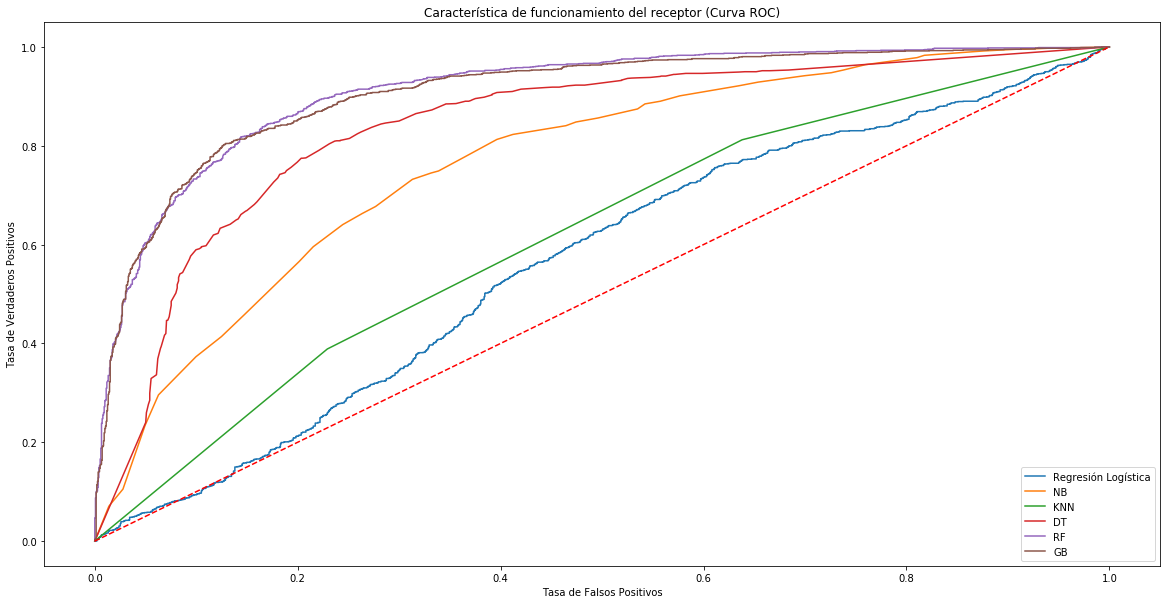

In [35]:
logit_fpr, logit_tpr, thresholds = roc_curve(y_test, logit.predict_log_proba(X_test)[:,1])
NB_fpr, NB_tpr, thresholds = roc_curve(y_test, NB_model.predict_proba(X_test)[:, 1])
KNN_fpr, KNN_tpr, thresholds = roc_curve(y_test, KNN_model.predict_proba(X_test)[:, 1])
DT_fpr, DT_tpr, thresholds = roc_curve(y_test, DT.predict_proba(X_test)[:, 1])
RF_fpr, RF_tpr, thresholds = roc_curve(y_test, RF.predict_proba(X_test)[:, 1])
GB_fpr, GB_tpr, thresholds = roc_curve(y_test, GB.predict_proba(X_test)[:, 1])

plt.figure(figsize=(20,10))
plt.plot(logit_fpr, logit_tpr, label='Regresión Logística')
plt.plot(NB_fpr, NB_tpr, label='NB')
plt.plot(KNN_fpr, KNN_tpr, label='KNN')
plt.plot(DT_fpr, DT_tpr, label='DT')
plt.plot(RF_fpr, RF_tpr, label='RF')
plt.plot(GB_fpr, GB_tpr, label='GB')
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Característica de funcionamiento del receptor (Curva ROC)')
plt.legend(loc="lower right")

En conclusión, considerando el mayor valor bajo la curva <b>AUC</b>, el mayor <b>Puntaje F1</b>, y el menor <b>MSE</b>, el mejor modelo para pronosticar si un cliente va a trasladarse de entidad bancaria o va a mantenerse en la actual es <b>Random Forest (RF)</b>.<br>
Sin embargo, la diferencia en los criterios de decisión entre éste y <b>Gradient Boosting (GB)</b> fue mínima. Y ya que la diferencia para decidir entre uno y otro es minúscula, vale la pena tener en cuenta teóricamente en qué se diferencia un modelo de otro, lo cual se realizará a continuación.

<h2> 2. Explique la diferencia entre un modelo de Random Forest y un modelo Gradient Boosting, utilice un ejemplo para sustentar su respuesta. </h2><br>

Primero cabe recalcar que ambos modelos comparten el hecho de ser <i>métodos de conjunto (o de aprendizaje en conjunto) [ensemble learning methods]</i> y a su vez están contenidos entre los métodos de regresión y clasificación que comprenden los <b>Árboles de Decisión [Decision Tree - DT]</b>, estos modelos (entre una amplia gama de opciones) pretenden resolver ciertas <b>desventajas</b> que llevan consigo los <b>Árboles de Decisión</b>. Por esta razón, cabe revisar las ventajas y desventajas de estos métodos para entender con mayor facilidad la utilidad y diferencias entre los modelos de RF y GB:

<center><b>DT - Ventajas</b></center>

<li>Los árboles son fáciles de interpretar aun cuando las relaciones entre predictores son complejas. Su estructura se asemejan a la forma intuitiva en que clasificamos y predecimos las personas, además, no se requieren conocimientos estadísticos para comprenderlos.</li>

<li>Los modelos basados en un solo árbol (no es el caso de random forest, boosting…) se pueden representar gráficamente aun cuando el número de predictores es mayor de 3.</li>

<li>Los árboles pueden manejar tanto predictores cuantitativos como cualitativos sin tener que crear variables dummy.</li>

<li>Al tratarse de métodos no paramétricos, no es necesario que se cumpla ningún tipo de distribución específica.</li>

<li>Por lo general, requieren mucha menos limpieza y pre procesado de los datos en comparación a otros métodos de aprendizaje estadístico.</li>

<li>No se ven muy influenciados por outliers.</li>

<li>Si para alguna observación, el valor de un predictor no está disponible, a pesar de no poder llegar a ningún nodo terminal, se puede conseguir una predicción empleando todas las observaciones que pertenecen al último nodo alcanzado. La precisión de la predicción se verá reducida pero al menos podrá obtenerse.</li>

<li>Son muy útiles en la exploración de datos, permiten identificar de forma rápida y eficiente las variables más importantes.</li>

<li>Son capaces de seleccionar predictores de forma automática.</li>
    
<center><b>DT - Desventajas</b></center>

<li>La capacidad predictiva de los modelos de regresión y clasificación basados en un único árbol es bastante inferior a la conseguida con otros modelos debido a su tendencia al overfitting. Sin embargo, existen técnicas más complejas que, haciendo uso de la combinación de múltiples árboles (bagging, random forest, boosting), consiguen mejorar en gran medida este problema.</li>

<li>Cuando tratan con variables continuas, pierden parte de su información al categorizarlas en el momento de la división de los nodos. Por esta razón, suelen ser modelos que consiguen mejores resultados en clasificación que en regresión.</li>

<li>La creación de las ramificaciones de los árboles se consigue mediante el algoritmo de recursive binary splitting. Este algoritmo identifica y evalúa las posibles divisiones de cada predictor acorde a una determinada medida (RSS, Gini, entropía…). Los predictores continuos o predictores cualitativos con muchos niveles tienen mayor probabilidad de contener, solo por azar, algún punto de corte óptimo, por lo que suelen verse favorecidos en la creación de los árboles.</li>
<center>Fuente:<br> https://www.cienciadedatos.net/documentos/33_arboles_de_prediccion_bagging_random_forest_boosting</center>

El problema más relevante se menciona en la primera desventaja. Dado que al ser la complejidad de los <b>Árboles de Decisión</b> relativamente baja, la flexibilidad de estos para adaptarse a los datos genera fácilmente <b>sobre-ajuste <i>[Overfitting]</i></b>. Esto refleja de suyo un problema interno de más cuidado:

<br><br><i>"Por lo general, los árboles pequeños (pocas ramificaciones) no representarán bien la relación entre las variables, por lo que tienen alto bias [Sesgo], pero poca varianza. Los árboles grandes se ajustan mucho a los datos de entrenamiento, por lo que tienen muy poco bias pero mucha varianza." (Íbid.)</i>

<br><br> Así queda de manifiesto que los <b>Árboles de Decisión</b> a pesar de su simplicidad y bondad son muy suceptibles a caer en un problema de Sesgo y/o Varianza [Bias - Variance] lo cual los lleva inevitablemente al problema de Overfitting. Con esto en mente se puede entender por qué los <i>métodos de conjunto</i> resultan importantes: Los modelos que trabajan bajo estas metodologías manejan una serie de técnicas que combinan varios modelos predictivos para lograr un equlibrio entre Bias y Variance. 

<center><h3> Random Forest </h3></center>

El método Random Forest consiste en generar múltiples árboles (de ahí que se use la metáfora del Bosque) de decisión completamente desarrollados (bajo sesgo, alta varianza). Este método aborda el término de error reduciendo la varianza. Los árboles no se correlacionan para así asegurar la mayor disminución de la varianza, sin embargo este algoritmo no puede reducir el sesgo (que es ligeramente mayor que el sesgo de un árbol individual en el bosque). De ahí la necesidad de árboles grandes, de modo que el sesgo sea inicialmente lo más bajo posible.

<center><h3> Gradient Boosting </h3></center>

Por otro lado, el método Gradient Boosting tiene como base un solo árbol de decisión pequeños (pocas ramificaciones = alto sesgo, baja varianza). Este es un método iterativo que aprovecha la la lectura del error del árbol pequeño con el que se trabaja para, en cada iteración, aprender secuencialmente del error anterior. Con base en esto, el modelo se concentra en reducir el error concentrándose en el sesgo. 

Finalmente, se toma una medida de tendencia central representativa para cada uno de los anteriores 2 métodos; bien puede ser un promedio (con variables continuas) o la moda (con variables cualitativas).

<h2> 3.Desarrolle un modelo que permita pronosticar el crecimiento del PIB de Colombia para el cuarto trimestre del año 2022. </h2>

<h3> a) Busque un conjunto de variables que permitan estimar el crecimiento del PIB en fuentes oficiales de información, como DANE, Banco Mundial, entre otras. </h3>

<h3> b) Defina el conjunto de parámetros a utilizar en la modelación, justificando su respuesta con apoyo de gráficos. </h3>

### <center> Regresión Univariada </center>

Al tratarse de un pronóstico a futuro, puede pensarse en varias formas de realizar la regresión y posterior pronóstico. Una de ella es utilizando la variable dependiente (Crecimiento del PIB) explicada por ella misma según su comportamiento pasado a lo largo del tiempo. En esta primera alternativa no se utilizará un análisis de regresión según variables exógenas que expliquen el crecimiento del PIB en Colombia, sino que se empleará un análisis de series de tiempo mediante el cual se explique el esta variable según el comportamiento temporal de ella misma variable junto con sus rezagos trimestralmente.
<br><br>Así, se iniciará por tomar los datos públicos oficiales del <b>DANE</b>, entre los cuales se comprende el periodo desde el 1995-1 hasta el 2020-1 para la tasa de crecimiento trimestral del PIB en Colombia.

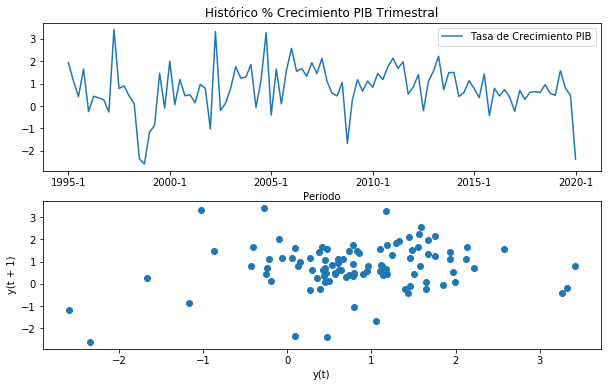

In [66]:
data = pd.read_csv("TaCrePIB.csv")
data.set_index('Periodo', inplace= True)

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (10,6))
data.plot(ax=ax1).set_title('Histórico % Crecimiento PIB Trimestral')
pd.plotting.lag_plot(data)
plt.show()

### <center> Regresión Multivariada </center>

Otra manera de abordar el problema para saber cuál método de regresión es mejor para ajustarse a los datos y su naturaleza temporal, además de que sea más eficiente a la hora de pronosticar, es utilizando una función de estimación multivariada en la cual se incluyan variables explicativas que también van a incluir sus respectivos rezagos temporales pues ellas mismas tambien son explicadas por su comportamiento en el pasado. Las variables seleccionadas a continuación también se obtuvieron mediante el DANE y el Banco de la República (BanRep) respectivamente:

### Tasa de Crecimiento del Desempleo:

Esta variable, fue elegida principalmente pensando en la empírica <b>Ley de Okun</b> la cual señala una aparente correlación entre el Desempleo en un País y su respectivo crecimiento de la economía (PIB). Claro está que dicha ley está enfocada al análisis del Desempleo y no, como en este caso, al crecimiento de la economía per se. Sin embargo, es una teoría que valdría la pena visualizar en los datos actuales (y no ya de los años 50) para Colombia (en vez de Estados Unidos donde se realizaron las primeras pruebas).

### Tasa de Intervención en Política Monetaria

La política monetaria es de los primeros temas elegidos por el Gobierno Nacional para mitigar el impacto del Coronavirus en Colombia (con observaciones previas de intervención en otros países de manera similar). A pesar de lo controversial que resulta hoy en día la pregunta por ¿hasta qué punto puede intervenir el gobierno en la política monetaria sin caer en problemas conocidos como la inflación y un efecto rebote en la economía? Por otro lado, está el salvavidas Keynesiano como lo llaman algunos, el cual está presente precisamente en estos tiempos de crisis económica. Por ambas razones, las cuales tienen un largo contexto de fondo que no se pretende exponer aquí sino meramente mencionar, parece importante ahora considerar cómo afecta la tasa de intervención en estas políticas al crecimiento de la economía precisamente en periodos de crisis. Para este fin me permito citar al autor Ramón E. Vélez quien, tras una análisis mediante un VAR (proceso que también se propone en este trabajo), concluye lo siguiente:

"La cantidad de dinero genera algunas fluctuaciones de corto plazo, es decir, en un horizonte de tiempo de 20 trimestres, el PIB crece durante los primeros nueve trimestres ante un shock monetario, para luego estabilizarse en su nivel inicial" (p. 14)

<center> Fuente: https://revistas.udem.edu.co/index.php/economico/article/download/1371/1427/ </center>

A contiuación se muestra el comportamiento temporal de las 3 variables disponibles para el análisis:

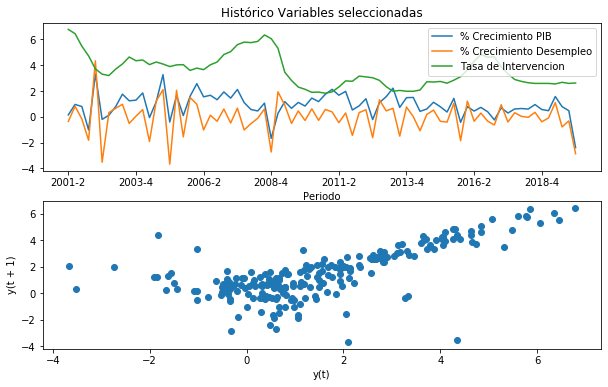

In [68]:
data2 = pd.read_csv("cointegradas.csv")
data2.set_index('Periodo', inplace= True)

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (10,6))
data2.plot(ax=ax1).set_title('Histórico Variables seleccionadas')
pd.plotting.lag_plot(data2)
plt.show()

<h3> c) Con las distintas técnicas conocidas, construya distintos modelos que pronóstiquen el crecimiento del PIB colombiano.</h3>

### <center> Univariado </center>

Adicional a lo ya mencionado, a continuación se realizará una prueba para conocer si la variable % Crecimiento del PIB es estacionaria (y así poder determinar si senecesita diferenciar la serie para empezar a crear los órdenes del proceso ARIMA):

#### ¿La Tasa de Crecimiento del PIB se comporta de manera estacionaria?

In [62]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None

    def ADF_Stationarity_Test(self, timeseries, printResults = True):
        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value
            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)

sTest = StationarityTests()
sTest.ADF_Stationarity_Test(data, printResults = True)
print("¿La Tasa de Crecimiento del PIB se comporta de manera estacionaria? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic      -4.575701
P-Value                  0.000143
# Lags Used              1.000000
# Observations Used     99.000000
Critical Value (1%)     -3.498198
Critical Value (5%)     -2.891208
Critical Value (10%)    -2.582596
dtype: float64
¿La Tasa de Crecimiento del PIB se comporta de manera estacionaria? True


Tras validar que es estacionaria sabemos que el proceso se reduce a un ARMA (p,q) o bien ARIMA (p,0,q), así que ahora se revisarán los valores óptimos para los órdenes del proceso AutoRegresivo(p) y del proceso de MediaMóvil(q). La combinación con el menor Akaike Information Criteria (AIC) o Bayesian Information Criteria (BIC) será el modelo más eficiente a la hora de ajustarse al comportamiento de correlación entre la variable y sus rezagos:

In [63]:
warnings.filterwarnings(action='ignore')
print("P Q       AIC            BIC")
for i in range(1,3):
    for j in range(3):
        model = ARIMA(data, order = (i,0,j))
        print(i, j, model.fit().aic, model.fit().bic)

P Q       AIC            BIC
1 0 297.8886850862012 305.73404663672494
1 1 296.19068568096355 306.6511677483286
1 2 294.0642466527079 307.1398492369142
2 0 293.7773456683157 304.23782773568075
2 1 295.4949531795712 308.5705557637775
2 2 294.283474121654 309.9741972227016


La combinación óptima es un <b>ARIMA(2,0,0)</b>, sabiendo esto se procede a hacer la evaluación de ajuste del modelo según el Mean Square Error (MSE) y se visualizan los datos (ROJO = Valor predicho por el modelo, AZUL CLARO = Valor real en la serie)

ARIMA MSE: 0.616


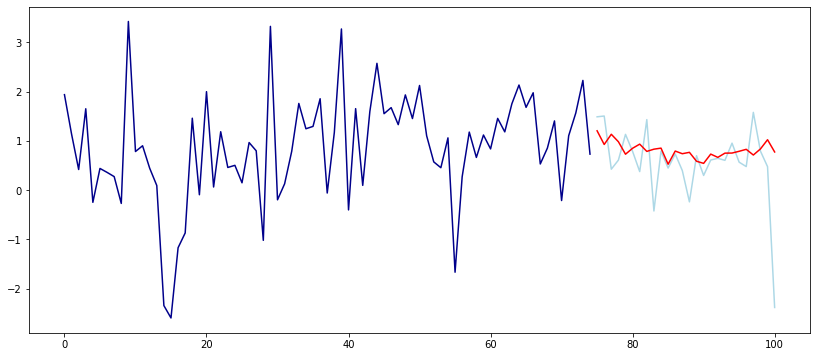

In [167]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
train, test = pm.model_selection.train_test_split(data.values, train_size=75)
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(2,0,0))
	model_fit = model.fit(disp=False)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	# print('predicted=%f, expected=%f' % (yhat, obs))
ARIMA_MSE = mean_squared_error(test, predictions)
print('ARIMA MSE: %.3f' % ARIMAMSE)
 #plot
x = np.arange(data.shape[0])
fig, ax = plt.subplots(nrows = 1, figsize = (14,6))
plt.plot(x[:75], train, c='darkblue')
plt.plot(x[75:], test, c='lightblue')
plt.plot(x[75:], predictions, c='red')
plt.show()

### <center> Multivariado </center>

Tras ver los resultados de la regresión y su respectivo ajuste ahora se pondrán a prueba los modelos VAR y VECM en los cuales se incluyen las variables <b>Tasa de Crecimiento del Desempleo</b> y <b>Tasa de Intervención en Política Monetaria</b>.

In [67]:
data2 = pd.read_csv("cointegradas.csv")
data2.set_index('Periodo', inplace= True)


sTest.ADF_Stationarity_Test(data2['% Crecimiento Desempleo'], printResults = True)
print("¿La Tasa de Crecimiento del Desempleo se comporta de manera estacionaria? {0}".format(sTest.isStationary))


sTest.ADF_Stationarity_Test(data2['Tasa de Intervencion'], printResults = True)
print("¿La Tasa de Intervención se comporta de manera estacionaria? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.084114e+01
P-Value                 1.614801e-19
# Lags Used             1.000000e+00
# Observations Used     7.400000e+01
Critical Value (1%)    -3.521980e+00
Critical Value (5%)    -2.901470e+00
Critical Value (10%)   -2.588072e+00
dtype: float64
¿La Tasa de Crecimiento del Desempleo se comporta de manera estacionaria? True
Augmented Dickey-Fuller Test Results:
ADF Test Statistic      -1.401083
P-Value                  0.581757
# Lags Used             12.000000
# Observations Used     63.000000
Critical Value (1%)     -3.538695
Critical Value (5%)     -2.908645
Critical Value (10%)    -2.591897
dtype: float64
¿La Tasa de Intervención se comporta de manera estacionaria? False


## VAR
A continuación se visualizan los datos bajo la estimación del método VAR (ROJO = Valor predicho por el modelo, AZUL CLARO = Valor real en la serie) y el MSE asociado a este modelo.

VAR MSE: 0.754


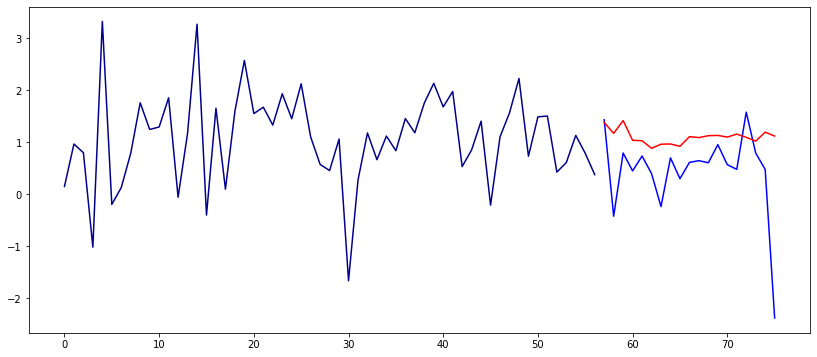

In [170]:
train, test = pm.model_selection.train_test_split(data2.values, train_size=57)
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = VAR(history)
	model_fit = model.fit()
	output = model_fit.forecast(model_fit.y, steps = 19)
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	# print('predicted=%f, expected=%f' % (yhat, obs))
VAR_MSE = mean_squared_error(test, predictions)
print('VAR MSE: %.3f' % VARMSE)
 #plot
    
x = np.arange(data2.shape[0])
fig, ax = plt.subplots(nrows = 1, figsize = (14,6))
plt.plot(x[:57], train[:,0], c='darkblue')
plt.plot(x[57:], test[:,0], c='blue')
plt.plot(x[57:], pd.DataFrame(predictions)[0], c='red')

#plt.plot(x[:57], train[:,1], c='green')
#plt.plot(x[57:], test[:,1], c='lightgreen')
#plt.plot(x[57:], pd.DataFrame(predictions)[1], c='red')
plt.show()

## VECM
Finalmente, se visualizan los datos bajo la estimación del último modelo de regresión tradicional VECM (ROJO = Valor predicho por el modelo, AZUL CLARO = Valor real en la serie) y el MSE asociado a este modelo.

In [47]:
from statsmodels.tsa.vector_ar.vecm import select_coint_rank

vec_rank1 = select_coint_rank(train, det_order = 1, k_ar_diff = 0, method = 'trace', signif = 0.05) 
print (vec_rank1.summary())

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   3          442.8          35.01
  1   3          42.74          18.40
  2   3          2.769          3.841
-------------------------------------


In [48]:
vec_rank2 = select_coint_rank(train, det_order = 1, k_ar_diff = 0, method = 'maxeig', signif = 0.05) 
print (vec_rank2.summary())

Johansen cointegration test using maximum eigenvalue test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          400.0          24.25
  1   2          39.97          17.15
  2   3          2.769          3.841
-------------------------------------


VECM MSE: 0.509


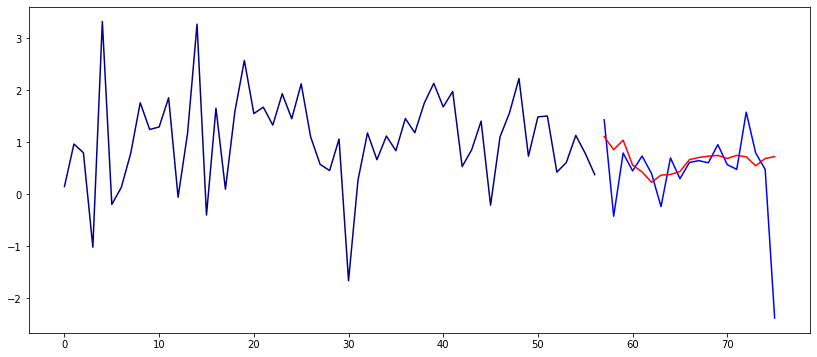

In [171]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = VECM(history, k_ar_diff = 0, coint_rank = 3, deterministic = "cili")
	model_fit = model.fit()
	output = model_fit.predict(steps = 19)
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	# print('predicted=%f, expected=%f' % (yhat, obs))
VECM_MSE = mean_squared_error(test, predictions)
print('VECM MSE: %.3f' % VECMMSE)
 #plot
    
x = np.arange(data2.shape[0])
fig, ax = plt.subplots(nrows = 1, figsize = (14,6))
plt.plot(x[:57], train[:,0], c='darkblue')
plt.plot(x[57:], test[:,0], c='blue')
plt.plot(x[57:], pd.DataFrame(predictions)[0], c='red')

#plt.plot(x[:57], train[:,1], c='green')
#plt.plot(x[57:], test[:,1], c='lightgreen')
#plt.plot(x[57:], pd.DataFrame(predictions)[1], c='red')
plt.show()

Ahora se revisarán los métodos No-Tradicionales para comparar su eficacia frente a los anteriores métodos comúnmente usados para series de tiempo:



## Decision Tree (DT)

In [159]:
X = pd.DataFrame(data2)
y = pd.DataFrame(data2['% Crecimiento PIB'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=57)

DT = DecisionTreeRegressor()
DT.fit(X_train,y_train)
DT_pred = DT.predict(X_test)
DT_MSE = mean_squared_error(y_test, DT_pred)

## Random Forest (RF)

In [157]:
RF = RandomForestRegressor()
RF.fit(X_train,y_train)
RF_pred = RF.predict(X_test)
RF_MSE = mean_squared_error(y_test, RF_pred)

## Gradient Boosting (GB)

In [161]:
GB = GradientBoostingRegressor()
GB.fit(X_train, y_train)
GB_pred = GB.predict(X_test)
GB_MSE = mean_squared_error(y_test, GB_pred)

## K-Nearliest Neighbons (KNN)

In [163]:
KNN = KNeighborsRegressor()
KNN_model = KNN.fit(X_train,y_train)
KNN_pred = KNN_model.predict(X_test)
KNN_MSE = mean_squared_error(y_test, KNN_pred)

<h3> d) ¿Cuál es el mejor modelo? Justifique su respuesta con apoyo de gráficos pertinentes. </h3>

Para la comparación de los modelos se utilizará acá solamente el Mean Square Error, en el punto #1 se observó que la decisión que otorga el MSE, el AUC_ROC y el F1 Score son congruentes y por lo tanto basta con 1 para decidir. Así, el modelo con el menor MSE asociado será el que mejor se ajusta a la naturaleza de los datos respecto a su posible pronóstico y será mediante el cual se responderá la pregunta rectora de este ejercicio.

In [173]:
print('     Modelo        ','      MSE Value         ')
print('ARIMA            : ', ARIMA_MSE)
print('VAR              : ', VAR_MSE)
print('VECM             : ', VECM_MSE)
print('K Near Neighbors : ', KNN_MSE)
print('Árbol de decisión: ', DT_MSE)
print('Random Forest    : ', RF_MSE)
print('Gradient Boosting: ', GB_MSE)

     Modelo               MSE Value         
ARIMA            :  0.6157528382850946
VAR              :  0.754169990165121
VECM             :  0.5089765171289299
K Near Neighbors :  0.3260110409862594
Árbol de decisión:  0.24007372873794539
Random Forest    :  0.10979125329964638
Gradient Boosting:  0.07558608877258272


### <center> Conclusión </center>

El mejor modelo para pronosticar el PIB en el contexto dado es Gradient Boosting. Esto cobra sentido al reconocer que este método se especializa en trabajar con relativamente pocas variables (como es el caso donde solo manejamos 3) y profundiza el aprendizaje que brinda cada una de ellas dentro de un solo árbol de decisión. Así mismo no era de esperarse que el mejor modelo fuera en este caso, por ejemplo, Random Forest ya que este método se especializa en grandes volúmenes de variables o de información de aprendizaje y trabajar de manera paralela con todas ellas obteniendo una media de todas las estimaciones realizadas.

<i>Nota: No supe cómo utilizar el método predict() sobre el modelo GradientBoosting utilizando los 76 registros temporales y por ello no pude brindar una respuesta puntual sobre ¿cuánto se espera que sea el PIB para el 2021-1? con el modelo ganador. Me gustaría saber cómo hacerlo dentro de la retroalimentación del trabajo ya que fue relativamente fácil realizar esto mismo con los ARIMA, VAR y VECM, pero en verdad no encontré cómo hacer algo semejante con este modelo. Gracias. </i>